# Generative AI and Risk Information

## What is Generative AI?

> Generative AI (GenAI) is a special type of Artificial Intelligence that can learn from and mimic large amounts of data to create content such as text, images, music, videos, code, and more.

## Application of Generative AI in Risk Management

- Information analysis
- Information provision
- Information automation

https://www.pwc.com/us/en/industries/financial-services/library/gen-ai-and-risk-management.html

### A Proof-of-Concept (PoC): Risk Agent

In this part of the course we will develop a conversational AI that provides seamless information about risks and challenges faced by publicly listed companies based on their annual reports. More precisely we will develop an application where a Large Language Model (LLM) orchestrates user queries to the annual reports that are relevant for the query. The user's query will then be enriched with information from the relevant reports which allows the LLM to come up with answers that closely reflect the information from the reports. In other words, the generated answers from the LLM are tuned by a retrieval mechanism that adds domain knowledge to the LLM's response which it otherwise would not have from its mere pretraining. This mechanism is called Retrieval Augmented Generation (RAG) and is a quite popular approach when developing conversational GenAI applications.

> LLMs, are very large deep learning models that are pre-trained on vast amounts of data. They are highly flexible as a single model can perform completely different generative tasks such as answering questions, summarizing documents, translating languages and completing sentences.

While risk-related information from company reports is publicly available, it is quite tedious and resource-intensive to collect and structure it and to make it seamless available to decision makers that act upon such information. For example,
- Financial Analysts and Investment Professionals such as portfolio managers, equity analysts, and hedge fund managers, need to assess the risks and challenges of companies to make informed investment decisions. A risk agent could help them quickly analyze risk disclosures in annual reports, saving time and improving accuracy.
- Corporate Risk Managers need to benchmark their own risk disclosures against competitors or industry standards. A risk agent could help them identify trends in risk reporting and ensure compliance with regulatory requirements.
- ESG analysts focus on evaluating companies' sustainability and governance practices. Risk disclosures in annual reports often include information about environmental and social risks, which are critical for ESG assessments. A risk agent could help them extracting and analyzing ESG-related risks from annual reports to evaluate a company's sustainability profile.

Developing LLM-based applications requires you to choose one of the many proprietary or open-source LLM models. We use the proprietary LLM `command-r-plus` from [Cohere](https://cohere.com/command). Cohere offers trial API keys that can be used to send calls to their LLMs and return responses free of charge. Cohere's trial keys are rate-limited, and cannot be used for commercial purposes.

In order to get a trial API key, [create an account](https://dashboard.cohere.com/welcome/register) on Cohere and generate a trial API key.


<img src="img/cohere.png" alt="Cohere trial key" width="1000">

In the root directory of this project simply create a new file named `.env` where you paste in your trial API key.

<img src="img/env.png" alt=".env file" width="700">

In the first step, we load the API keys into your project's environment, so the keys are available to us.

In [21]:
import os
from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()

# Access the API keys
cohere_api_key = os.getenv("COHERE_API_KEY")
huggingface_api_key = os.getenv("HUGGINGFACE_API_KEY")

Moving on, we will primarily work with [LlamaIndex](https://docs.llamaindex.ai/en/stable/) which is one of the leading frameworks for building LLM-powered agents.

> Agents are LLM-powered knowledge assistants that use tools to perform tasks like research, data extraction, and more. Agents range from simple question-answering to being able to sense, decide and take actions in order to complete tasks.

LlamaIndex provides the following tools that formalize the development of search agents:
- **Data connectors** (Readers) ingest existing data from their native source and format. These could be APIs, PDFs, SQL databases, and others.
- **Data indexes** structure your data in intermediate representations that are easy and performant for LLMs to consume.
- **Engines** provide natural language access to your data. For example:
    - Query engines are powerful interfaces for question-answering (e.g. a RAG flow).
    - Chat engines are conversational interfaces for multi-message, "back and forth" interactions with your data.
- **Agents** are LLM-powered knowledge workers augmented by tools, from simple helper functions to API integrations and more.

In our use case, we develop an agent capable of extracting risk-related information from annual company reports. The agent orchestrates which report to retrieve information from based on the user's query. The illustration below provides an idea of what such a system may look like.

<img src="img/multi_doc_agent.webp" alt="Multi-document agent" width="900">
<p>Image source: <a href="https://pub.towardsai.net/advanced-rag-techniques-an-illustrated-overview-04d193d8fec6">Ivan Ilin</a></p>

## Developing a Mulit-Document Risk Agent

### Read documents

For demonstrative purposes, the original annual reports for a sample of DAX 40 companies can be found in `data/raw/reports/`.

In [2]:
reports = os.listdir('data/raw/reports/')
reports

['adidas_2023.pdf',
 'allianz_2023.pdf',
 'basf_2023.pdf',
 'bayer_2023.pdf',
 'beiersdorf_2023.pdf',
 'bmw_2023.pdf']

To read the annual reports we use `SimpleDirectoryReader` which provides a simple and straightforward way to load data from local files and parse the text found in them automatically selecting the best file reader based on the file extensions.

In [22]:
from llama_index.core import SimpleDirectoryReader

documents = SimpleDirectoryReader('data/raw/reports/').load_data(show_progress=True)
print(f"In total {len(documents)} Document objects have been loaded.")

Loading files:   0%|          | 0/6 [00:10<?, ?file/s]


KeyboardInterrupt: 

As you can see `SimpleDirectoryReader` returns a list of `Document` objects where each element represents a single page from the annual reports loaded before.

In [4]:
documents[0:3]

[Document(id_='af18be04-5b86-4850-9610-5373becd4164', embedding=None, metadata={'page_label': '1', 'file_name': 'adidas_2023.pdf', 'file_path': 'w:\\teaching\\risk_analytics\\data\\raw\\reports\\adidas_2023.pdf', 'file_type': 'application/pdf', 'file_size': 20968677, 'creation_date': '2025-02-02', 'last_modified_date': '2025-02-02'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='2023\nANNUAL REPORT', path=None, url=None, mimetype=None), image_resource=None, audio_resource=None, video_resource=None, text_template='{metadata_str}\n\n{content}'),
 Document(id_='c0cefd32-38fd-4ef8-af8a-5b83afe5b63e', embedding=None, metadata={'page_label': '

A `Document` object comes with a unique ID, some metadate, and the data found in the document by data type:
- text_resource
- image_resource
- audio_resource
- video_resource

In [5]:
vars(documents[100])

{'id_': 'e83dd70e-17a0-45fd-957e-f1e85c74f2c1',
 'embedding': None,
 'metadata': {'page_label': '101',
  'file_name': 'adidas_2023.pdf',
  'file_path': 'w:\\teaching\\risk_analytics\\data\\raw\\reports\\adidas_2023.pdf',
  'file_type': 'application/pdf',
  'file_size': 20968677,
  'creation_date': '2025-02-02',
  'last_modified_date': '2025-02-02'},
 'excluded_embed_metadata_keys': ['file_name',
  'file_type',
  'file_size',
  'creation_date',
  'last_modified_date',
  'last_accessed_date'],
 'excluded_llm_metadata_keys': ['file_name',
  'file_type',
  'file_size',
  'creation_date',
  'last_modified_date',
  'last_accessed_date'],
 'relationships': {},
 'metadata_template': '{key}: {value}',
 'metadata_separator': '\n',
 'text_resource': MediaResource(embeddings=None, data=None, text='1 2 3 4 5 \nT O  O U R SHA REHO L D ERS  GRO U P  MAN A GEMEN T  REP O RT – \nO U R CO MPA N Y \nGRO U P  MAN A GEMEN T  REP O RT – \nF I N A N CI AL  REVI EW \nCO N SO L I DA T ED  FI N AN CI A L \nST A

Next, we use the custom function `display_document_with_image_side_by_side()` to display and compare the text parsed by `SimpleDirectoryReader` with the original.

In [6]:
from util import display_document_with_image_side_by_side

display_document_with_image_side_by_side(
    document=documents[165],
    image_path='img/annual_report.png'
)

When using the text_resource in the Risk Agent, we do not need the header information which repeats on each page. This is just convoluting the content and should be removed from the `Document` objects. Similar redundant text can be found in the annual reports of the other companies. Moreover, we do not want to use the entire annual reports but only the pages which contain information about the companies' 'Risk and Opportunity'. Ultimately, we want to merge all relevant pages of one annual report into a single `Document` object. Otherwise, paragraphs that split across two pages will be handled separately in downstream processing.

In [23]:
pre_process_dict = {
    "adidas": {
        "pages": range(165, 187, 1),
        "string_to_remove": "1 2 3 4 5 \nT O  O U R SHA REHO L D ERS  GRO U P  MAN A GEMEN T  REP O RT – \nO U R CO MPA N Y \nGRO U P  MAN A GEMEN T  REP O RT – \nF I N A N CI AL  REVI EW  \nCO N SO L I DA T ED  FI N AN CI A L \nST A T EMEN T S \nA D D I T I ON A L I N FO RMA T I ON \n \n\\d{1,3} \n    \n    \n A N N U A L  R E P O R T  2 0 2 3",
    },
    "allianz": {
        "pages": range(21, 37, 1),
        "string_to_remove": "B _ Management Report of Allianz SE \n\\d{1,3} Annual Report 2023 – Allianz SE \n"
    },
    "basf": {
        "pages": range(172, 183, 1),
        "string_to_remove": "Combined Management’s Report – Opportunities and Risks\n"
    },
    "bayer": {
        "pages": range(99, 116, 1),
        "string_to_remove": " \n \nBayer Annual Report 2023 A Combined Management Report\n3.2 Opportunity and Risk Report\n \\d{1,3}\n"
    },
    "beiersdorf": {
        "pages": range(155, 166, 1),
        "string_to_remove": " \n \nBeiersdorf Annual Report 2023 A Combined Management Report\n3.2 Opportunity and Risk Report\n \\d{1,3}\n"
    },
    "bmw": {
        "pages": range(126, 142, 1),
        "string_to_remove": "\\d{1,3} BMW Group Report 2023\\s+To Our Stakeholders\\s+Combined Management Report\\s+Group Financial Statements\\s+Responsibility Statement and Auditor’s Report\\s+Remuneration Report\\s+Other Information\\s+\n\\s+Risks and Opportunities\\s+\n"
    }
}

In [5]:
from llama_index.core import Document, SimpleDirectoryReader
import re
from typing import Optional, Dict, List, Union


def pre_process_document(
        report_file_path: str, 
        pre_process_dict: Optional[Dict[str, Dict[str, Union[range, str]]]] = None, 
        company: str = None,
        year: int = None) -> List[Document]:
    """
    Pre-processes a document by loading it from the specified file path, optionally removing specified strings,
    and returning a list of Document objects containing the processed text.

    Args:
        report_file_path (str): The path to the report file to be processed.
        pre_process_dict (Optional[Dict[str, Dict[str, Union[range, str]]]]): A dictionary containing optional parameters for 
            pre-processing for different entities. Each key corresponds to an entity (e.g., 'adidas', 'allianz') and 
            maps to another dictionary with:
            - 'pages' (range): A range of page indices to process.
            - 'string_to_remove' (str): A regex pattern for strings to be removed from the document text.

    Returns:
        List[Document]: A list containing a single Document object with the processed text.
    """
    
    documents = SimpleDirectoryReader(input_files=[report_file_path]).load_data(show_progress=False)
    
    overall_text = ""
    
    if pre_process_dict is not None:
        string_to_remove = pre_process_dict.get('string_to_remove')
        pages = pre_process_dict.get('pages', range(0, len(documents), 1))  # Default to all pages if not specified
        
        for page in pages:
            document = documents[page]
            text = document.text
            if string_to_remove is not None:
                text = re.sub(string_to_remove, "", text)
            overall_text = "\n".join([overall_text, text])
    else:
        # If no pre_process_dict is provided, process all pages
        for page in range(len(documents)):
            document = documents[page]
            overall_text = "\n".join([overall_text, document.text])

    documents = [Document(text=overall_text, metadata={'company': company, 'year': year})]
    
    return documents

In [6]:
document = pre_process_document('data/raw/reports/beiersdorf_2023.pdf', pre_process_dict.get('beiersdorf'), company='beiersdorf', year=2023)

In [7]:
document

[Document(id_='3b59e813-2444-48c5-93ce-84af58bdddb3', embedding=None, metadata={'company': 'beiersdorf', 'year': 2023}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={}, metadata_template='{key}: {value}', metadata_separator='\n', text_resource=MediaResource(embeddings=None, data=None, text='\nRisk Report\nRisks and opportunities\nIn the course of its business activities, the Beiersdorf Group is exposed to a multitude of risks and \nopportunities. These risks and opportunities result, among other things, from its activities that seek to \ndevelop and make use of opportunities to improve the company’s competitiveness. Risks and \nopportunities encompass specific events and developments with a certain probability of occurrence \nthat may have material negative or positive financial and/or non-financial effects on the achievement of \nthe Beiersdorf Group’s objectives. Beiersdorf uses an integrated risk and opportunity management \nsystem to identify and ev

In [8]:
import pprint
pprint.pp(document[0].text)

('Risk Report\n'
 'Risks and opportunities\n'
 'In the course of its business activities, the Beiersdorf Group is exposed to '
 'a multitude of risks and \n'
 'opportunities. These risks and opportunities result, among other things, '
 'from its activities that seek to \n'
 'develop and make use of opportunities to improve the company’s '
 'competitiveness. Risks and \n'
 'opportunities encompass specific events and developments with a certain '
 'probability of occurrence \n'
 'that may have material negative or positive financial and/or non-financial '
 'effects on the achievement of \n'
 'the Beiersdorf Group’s objectives. Beiersdorf uses an integrated risk and '
 'opportunity management \n'
 'system to identify and evaluate material risks at an early stage and to '
 'consistently limit them using \n'
 'counteractive measures. This system is coordinated at Group headquarters.\n'
 'Beiersdorf Risk Radar\n'
 'Schematic diagram\n'
 'Integrated risk and opportunity management system\n'


In [ ]:
from llama_index.core.node_parser import SentenceSplitter

def chunk_document(
    document: Document,
    chunk_size: int = 512,
    chunk_overlap: int = 50,
    separator: str = ' ',
    paragraph_separator: str = '\n\n\n'):
    
    splitter = SentenceSplitter(
        separator=separator, 
        chunk_size=chunk_size, 
        chunk_overlap=chunk_overlap, 
        paragraph_separator=paragraph_separator,
        include_metadata=True)
    chunks = splitter.get_nodes_from_documents(document)

    return chunks

In [10]:
document_nodes = chunk_document(document)

In [11]:
for index, node in enumerate(document_nodes):
    pprint.pp(f"Node {index}: {node.text[:100]} ...")

('Node 0: Risk Report\n'
 'Risks and opportunities\n'
 'In the course of its business activities, the Beiersdorf Group i ...')
('Node 1: In cases where the full avoidance of risks is not possible or '
 'reasonable, risks are mitigated \n'
 'using ...')
('Node 2: For each category, the risks are also classified based on their '
 'probability and the potential financ ...')
('Node 3: To ensure maximum transparency and accountability, Beiersdorf’s '
 'financial risk-bearing capacity is \n'
 ' ...')
('Node 4: In addition, in line with our cautious approach, we have currently '
 'completely removed \n'
 'opportunities ...')
('Node 5: 2. Critical ingredients\n'
 'For a clearer distinction and risk assessment, we have presented the risk ar '
 '...')
('Node 6: Our data protection management system, \n'
 'globally steered and locally implemented, helps us ensure th ...')
('Node 7: 5. Shortage of raw materials, natural resources, and energy\n'
 'The general procurement situation has im ...')
('No

In [69]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS
from langchain_community.vectorstores.utils import DistanceStrategy
from langchain_huggingface import HuggingFaceEmbeddings
from util import convert_llama_to_langchain

async def vectorize_chunks(
    chunks: List[Document], 
    model_name: str = "Snowflake/snowflake-arctic-embed-l-v2.0",
    device: str = 'cpu',
    normalize_embeddings: bool = False,
    distance_strategy: str = DistanceStrategy.COSINE) -> FAISS:
    
    embed_model = HuggingFaceEmbeddings(
        model_name=model_name,
        model_kwargs={'device': device},
        encode_kwargs={'normalize_embeddings': normalize_embeddings}
    )

    index = faiss.IndexFlatL2(len(embed_model.embed_query("hello world")))

    vector_store = FAISS(
        embedding_function=embed_model,
        index=index,
        docstore=InMemoryDocstore(),
        index_to_docstore_id={},
        distance_strategy=distance_strategy
    )

    await vector_store.aadd_documents(documents=chunks)
    
    return vector_store

In [101]:
del vector_store

In [ ]:
from tqdm import tqdm
import asyncio
import nest_asyncio
nest_asyncio.apply()

for report in tqdm(reports):
    company = report.split('_')[0]
    year = int(report.split('_')[1].split('.')[0])

    document = pre_process_document(
        f'data/raw/reports/{report}', 
        pre_process_dict.get(company), 
        company=company, 
        year=year)
    document_chunks = chunk_document(
        document, 
        chunk_size=200, 
        chunk_overlap=50, 
        separator=' ', 
        paragraph_separator='\n\n\n')
    
    document_chunks = [convert_llama_to_langchain(chunk) for chunk in document_chunks]
    
    try:
        await vector_store.aadd_documents(document_chunks)
        print(f"Vector store updated for {company} {year}.")
    except Exception as e:
        # Handle errors and debug
        print(f"Error updating vector store for {company} {year}: {e}")
        
        # If vector_index doesn't exist, create it
        if 'vector_store' not in locals():
            vector_store = asyncio.run(vectorize_chunks(document_chunks))
            print(f"Vector store created for {company} {year}.")
        else:
            print(f"Skipping {company} {year} due to error.")

 25%|██▌       | 1/4 [00:55<02:45, 55.18s/it]

Vector store updated for basf 2023.


In [105]:
set([(doc.metadata['company'], doc.metadata['year']) for doc in vector_store.get_by_ids(vector_store.index_to_docstore_id.values())])

{('adidas', 2023), ('allianz', 2023)}

In [ ]:
retriever = vector_store.as_retriever(
    search_kwargs={"k": 5,
                   'score_threshold': 0.2},
    search_type="similarity_score_threshold"
)

retriever.invoke("Is Beiersdorf facing climate risks?", filter={"company": "adidas", "year": 2023})

No relevant docs were retrieved using the relevance score threshold 0.0


[]

In [ ]:
vector_store.save_local("/studio/faiss_vetor_store")

In [ ]:
from llama_index.core import VectorStoreIndex
from llama_index.embeddings.huggingface import HuggingFaceEmbedding

#from llama_index.embeddings.huggingface_api import HuggingFaceInferenceAPIEmbedding
import asyncio
import nest_asyncio
nest_asyncio.apply()


async def vectorize_chunks(nodes):
    vector_index = VectorStoreIndex(
            nodes=nodes,
            embed_model=HuggingFaceEmbedding(model_name="Snowflake/snowflake-arctic-embed-l-v2.0")
            #embed_model=HuggingFaceInferenceAPIEmbedding(model_name="Snowflake/snowflake-arctic-embed-l-v2.0", token=huggingface_api_key)
            )

    return vector_index

In [ ]:
# Now you can run your async function normally
vector_index = asyncio.run(vectorize_chunks(document_nodes))

In [23]:
vector_index._get_node_with_embedding(document_nodes)

[TextNode(id_='781d0ccb-d11c-493e-bd33-81a11939c782', embedding=[-0.015917334705591202, -0.019641034305095673, 0.010428122244775295, 0.0008497417438775301, 0.009922894649207592, 0.031402334570884705, -0.017038967460393906, 0.007792306132614613, -0.008863626979291439, 0.04437067732214928, -0.006957302335649729, 0.010220441967248917, 0.038859374821186066, 0.006628100760281086, 0.08996370434761047, 0.04402540996670723, 0.1030542328953743, 0.00731679517775774, -0.017595889046788216, 0.04197387397289276, -0.019407998770475388, -0.009175913408398628, -0.04725276306271553, -0.022939695045351982, -0.04847952723503113, 0.043016329407691956, -0.03248164802789688, -0.03153638541698456, 0.08867489546537399, 0.12910380959510803, 0.004317666403949261, -0.0020828028209507465, -0.04475643113255501, -0.004861549474298954, 0.035720039159059525, -0.07829830050468445, 0.04240421578288078, -0.05089348927140236, -0.07867981493473053, 0.029844757169485092, -0.02244299277663231, 0.061925772577524185, 0.105236

In [7]:
from tqdm import tqdm
for report in tqdm(reports):
    company = report.split('_')[0]
    year = int(report.split('_')[1].split('.')[0])

    document = pre_process_document(
        f'data/raw/reports/{report}', 
        pre_process_dict.get(company), 
        company=company, 
        year=year)
    document_nodes = chunk_document(
        document, 
        chunk_size=200, 
        chunk_overlap=50, 
        separator=' ', 
        paragraph_separator='\n\n\n')
    
    try:
        vector_index.insert_nodes(document_nodes)
        print(f"Vector index updated for {company} {year}.")
    except Exception as e:
        # Handle errors and debug
        print(f"Error updating vector index for {company} {year}: {e}")
        
        # If vector_index doesn't exist, create it
        if 'vector_index' not in locals():
            vector_index = asyncio.run(vectorize_chunks(document_nodes))
            print(f"Vector index created for {company} {year}.")
        else:
            print(f"Skipping {company} {year} due to error.")

  0%|          | 0/6 [00:00<?, ?it/s]

Error updating vector index for adidas 2023: name 'vector_index' is not defined


 17%|█▋        | 1/6 [01:35<07:57, 95.52s/it]

Vector index created for adidas 2023.


 33%|███▎      | 2/6 [03:18<06:40, 100.08s/it]

Vector index updated for allianz 2023.


 50%|█████     | 3/6 [04:12<03:57, 79.09s/it] 

Vector index updated for basf 2023.


 67%|██████▋   | 4/6 [05:16<02:26, 73.16s/it]

Vector index updated for bayer 2023.


 83%|████████▎ | 5/6 [05:59<01:02, 62.25s/it]

Vector index updated for beiersdorf 2023.


100%|██████████| 6/6 [07:16<00:00, 72.76s/it]

Vector index updated for bmw 2023.


In [ ]:
vector_index.storage_context.persist(
    persist_dir=f"./studio/vector_index"
)

In [ ]:
from llama_index.core import load_index_from_storage, StorageContext

vector_index = load_index_from_storage(
    StorageContext.from_defaults(
        persist_dir=f"./studio/vector_index"
    )
)

In [2]:
set([n.metadata.get('company') for n in list(vector_index.docstore.docs.values())])

{'adidas', 'allianz', 'basf', 'bayer', 'beiersdorf', 'bmw'}

In [ ]:
from llama_index.core.vector_stores import MetadataInfo, VectorStoreInfo

vector_store_info = VectorStoreInfo(
    content_info="Annual reports of DAX 40 companies",
    metadata_info=[
        MetadataInfo(
            name="company",
            description="To which company the annual report belongs",
            type="string",
        ),
        MetadataInfo(
            name="year",
            description="The business year of the annual report",
            type="integer",
        ),
    ],
)

In [45]:
from llama_index.core.retrievers import VectorIndexAutoRetriever
from llama_index.embeddings.huggingface_api import HuggingFaceInferenceAPIEmbedding

retriever = VectorIndexAutoRetriever(
    vector_index,
    vector_store_info=vector_store_info,
    similarity_top_k=2,
    empty_query_top_k=10,  # if only metadata filters are specified, this is the limit
    verbose=True,
    embed_model=HuggingFaceInferenceAPIEmbedding(model_name="Snowflake/snowflake-arctic-embed-l-v2.0", token=huggingface_api_key),
)

In [42]:
from llama_index.core.vector_stores import MetadataFilter, MetadataFilters, FilterOperator

filters = MetadataFilters(
    filters=[
        MetadataFilter(key="company", operator=FilterOperator.EQ, value="Bayer"),
    ]
)

retriever = vector_index.as_retriever(filters=filters, similarity_top_k=3)

In [59]:
context = retriever.retrieve("Which risk protection methods does Beiersdorf implement in 2022?")

Using query str: risk protection methods Beiersdorf 2022
Using filters: [('company', '==', 'Beiersdorf'), ('year', '==', '2022')]


In [60]:
context

[]

In [62]:
for index, c in enumerate(context):
    pprint.pp(f"Context {index}: {c.text[:100]} ...")

('Context 0: Unethical business practices or improper behavior on the part of '
 'business partners could \n'
 'have a neg ...')
('Context 1: In addition, our business \n'
 'activities could be impacted by port congestions, strikes, riots, armed c '
 '...')


In [ ]:
from llama_index.core import (
    Settings,
    load_index_from_storage,
    SummaryIndex,
    VectorStoreIndex,
    StorageContext
)
from llama_index.core.postprocessor import SimilarityPostprocessor
from llama_index.llms.cohere import Cohere
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.embeddings.huggingface_api import HuggingFaceInferenceAPIEmbedding
from tqdm import tqdm
from llama_index.core.tools import QueryEngineTool, ToolMetadata
from llama_index.core.node_parser import SentenceSplitter
from llama_index.core.objects import ObjectIndex
from pathlib import Path
from llama_index.core.agent import FunctionCallingAgentWorker
from llama_index.core.agent import AgentRunner

In [24]:
companies = [
    'adidas',
    'allianz',
    'basf',
    'bayer',
    'beiersdorf',
    'bmw'
    ]

year = '2023'

In [ ]:
async def create_doc_tools(
    company_fp: str,
    company: int,
    post_process: dict = None,
    llm_model = Cohere(model="command-r-plus", api_key=cohere_api_key),
    embed_model = HuggingFaceInferenceAPIEmbedding(model_name="Snowflake/snowflake-arctic-embed-l-v2.0", token=huggingface_api_key),
) -> AgentRunner:
    
    # LLM model
    Settings.llm = llm_model
    # embedding model
    Settings.embed_model = embed_model

    if not os.path.exists(f"./data/reports/{company}"):
        # load pdf documents
        documents = SimpleDirectoryReader(input_files=[company_fp]).load_data()

        if post_process is not None:
            overall_text = ""
            string_to_remove = post_process.get('string_to_remove')
            for page in post_process.get('pages'):
                document = documents[page]
                text = document.text
                if string_to_remove is not None:
                    text = re.sub(string_to_remove, "", text)
                overall_text = "\n".join([overall_text, text])
            documents = [Document(text=overall_text)]
        
        splitter = SentenceSplitter()
        nodes = splitter.get_nodes_from_documents(documents)

        # summary index
        summary_index = SummaryIndex(nodes)
        summary_index.storage_context.persist(
            persist_dir=f"./data/reports/{company}/summary_index"
        )
        # vector store index
        vector_index = VectorStoreIndex(
            nodes,
            embed_model=Settings.embed_model)
        vector_index.storage_context.persist(
            persist_dir=f"./data/reports/{company}/vector_index"
        )
    
    else:
        summary_index = load_index_from_storage(
            StorageContext.from_defaults(
                persist_dir=f"./data/reports/{company}/summary_index"
            )
        )
        vector_index = load_index_from_storage(
            StorageContext.from_defaults(
                persist_dir=f"./data/reports/{company}/vector_index"
            )
        )


    # Summary query engine based on a
    # simple retriever returns all nodes
    summary_query_engine = summary_index.as_query_engine()

    # Vector query engine based on a
    # vector index retriever that only returns the top k results
    vector_query_engine = vector_index.as_query_engine(similarity_top_k=2)

    # define tools
    query_engine_tools = [
        QueryEngineTool.from_defaults(
            name=f"{company}_summary_tool",
            query_engine=summary_query_engine,
            description=(
                f"Useful for summarization questions related to the risks outlined in the annual report of {company}."
            ),
        ),

        QueryEngineTool.from_defaults(
            name=f"{company}_vector_tool",
            query_engine=vector_query_engine,
            description=(
                f"Useful for retrieving specific context concerning {company}'s risks and challenges as highlighted in its annual report."
            ),
        )
    ]

    agent_worker = FunctionCallingAgentWorker.from_tools(
        query_engine_tools, 
        llm=Settings.llm, 
        verbose=True,
        system_prompt=f"""
        You are an agent designed to answer queries about the company {company} which can be answered based on paragraphs 
        from their annual reports where they outline their risks and challenges.
        


        Please always use the tools provided to answer a question. Do NOT rely on prior knowledge.
        """
    )
    agent = AgentRunner(agent_worker)

    return agent

In [37]:
agents = {}
for company in tqdm(companies):
    agent = await create_doc_tools(
        company_fp = Path(f"./data/raw/reports/{company}_{year}.pdf"),
        company = company,
        post_process = post_process[company])
    agents[company] = agent

100%|██████████| 6/6 [00:01<00:00,  5.95it/s]


In [28]:
# define tool for each document agent
all_tools = []
for company in tqdm(companies):
    report_summary = (
        f"This content contains information about {company}'s annual report. Use"
        f" this tool if you want to answer any questions about {company}.\n"
    )
    doc_tool = QueryEngineTool(
        query_engine=agents[company],
        metadata=ToolMetadata(
            name=f"tool_{company}",
            description=report_summary,
        ),
    )
    all_tools.append(doc_tool)

100%|██████████| 6/6 [00:00<?, ?it/s]


In [30]:
obj_index = ObjectIndex.from_objects(
    all_tools,
    index_cls=VectorStoreIndex,
)

RuntimeError: Cannot run the event loop while another loop is running

In [23]:
top_agent_worker = FunctionCallingAgentWorker.from_tools(
    tool_retriever=obj_index.as_retriever(
        similarity_top_k=3,
        node_postprocessors=[SimilarityPostprocessor(similarity_cutoff=0.8)]
        ),
    system_prompt="""
        You are an agent designed to answer queries about a set of given companies.
        Please always try to use the tools provided to answer a question. 
        If none of the tools can be used to answer the question, respond to the user
        that you do not have any information available about the company he is asking.\n
        """,
    verbose=True
)

top_agent = AgentRunner(top_agent_worker)

In [16]:
agent.chat("What does the Norvatis mention about litigation risks in its annual report?")

Added user message to memory: What does the Norvatis mention about litigation risks in its annual report?
=== LLM Response ===
I'm sorry, I can only answer questions about BMW.


AgentChatResponse(response="I'm sorry, I can only answer questions about BMW.", sources=[], source_nodes=[], is_dummy_stream=False, metadata=None)

In [24]:
response = top_agent.chat("Do BMW or Astra Zeneca face residual value risks and how they mitigate these risks?")

Added user message to memory: Do BMW or Astra Zeneca face residual value risks and how they mitigate these risks?
=== LLM Response ===
I can provide some general information about residual value risk, but I don't have specific risk mitigation strategies for BMW or AstraZeneca. Here's what I can tell you:

Residual value risk is the potential financial risk associated with the future value of an asset at the end of its lease or useful life. This risk is relevant for companies that deal with assets that depreciate over time, such as vehicles or equipment.

For BMW, which is an automotive manufacturer, residual value risk is a significant concern. The residual value of their vehicles can impact the company's financial performance and profitability. BMW may face residual value risk due to factors such as changing consumer preferences, advancements in technology, or economic conditions that could affect the future value of their cars.

To mitigate residual value risk, automotive companies l

Resources:
- [Let's talk about LlamaIndex and LangChain](https://superwise.ai/blog/lets-talk-about-llamaindex-and-langchain/)
- [LlamaIndex](https://docs.llamaindex.ai/en/stable/)
- [Advanced RAG techniques - An illustrated overview](https://pub.towardsai.net/advanced-rag-techniques-an-illustrated-overview-04d193d8fec6)

Try it with LangChain & LangGraph

In [1]:
import os

reports = os.listdir('data/raw/reports/')
reports

['adidas_2023.pdf',
 'allianz_2023.pdf',
 'basf_2023.pdf',
 'bayer_2023.pdf',
 'beiersdorf_2023.pdf',
 'bmw_2023.pdf']

In [2]:
pre_process_dict = {
    "adidas": {
        "pages": range(165, 187, 1),
        "string_to_remove": "1 2 3 4 5 \nT O  O U R SHA REHO L D ERS  GRO U P  MAN A GEMEN T  REP O RT – \nO U R CO MPA N Y \nGRO U P  MAN A GEMEN T  REP O RT – \nF I N A N CI AL  REVI EW  \nCO N SO L I DA T ED  FI N AN CI A L \nST A T EMEN T S \nA D D I T I ON A L I N FO RMA T I ON \n \n\\d{1,3} \n    \n    \n A N N U A L  R E P O R T  2 0 2 3",
    },
    "allianz": {
        "pages": range(21, 37, 1),
        "string_to_remove": "B _ Management Report of Allianz SE \n\\d{1,3} Annual Report 2023 – Allianz SE \n"
    },
    "basf": {
        "pages": range(172, 183, 1),
        "string_to_remove": "Combined Management’s Report – Opportunities and Risks\n"
    },
    "bayer": {
        "pages": range(99, 116, 1),
        "string_to_remove": " \n \nBayer Annual Report 2023 A Combined Management Report\n3.2 Opportunity and Risk Report\n \\d{1,3}\n"
    },
    "beiersdorf": {
        "pages": range(155, 166, 1),
        "string_to_remove": " \n \nBeiersdorf Annual Report 2023 A Combined Management Report\n3.2 Opportunity and Risk Report\n \\d{1,3}\n"
    },
    "bmw": {
        "pages": range(126, 142, 1),
        "string_to_remove": "\\d{1,3} BMW Group Report 2023\\s+To Our Stakeholders\\s+Combined Management Report\\s+Group Financial Statements\\s+Responsibility Statement and Auditor’s Report\\s+Remuneration Report\\s+Other Information\\s+\n\\s+Risks and Opportunities\\s+\n"
    }
}

In [3]:
from langchain_core.documents import Document
from langchain_community.document_loaders import PyPDFLoader
import re
from typing import Optional, Dict, List, Union


def pre_process_document(
        report_file_path: str, 
        pre_process_dict: Optional[Dict[str, Dict[str, Union[range, str]]]] = None, 
        company: str = None,
        year: int = None) -> List[Document]:
    """
    Pre-processes a document by loading it from the specified file path, optionally removing specified strings,
    and returning a list of Document objects containing the processed text.

    Args:
        report_file_path (str): The path to the report file to be processed.
        pre_process_dict (Optional[Dict[str, Dict[str, Union[range, str]]]]): A dictionary containing optional parameters for 
            pre-processing for different entities. Each key corresponds to an entity (e.g., 'adidas', 'allianz') and 
            maps to another dictionary with:
            - 'pages' (range): A range of page indices to process.
            - 'string_to_remove' (str): A regex pattern for strings to be removed from the document text.

    Returns:
        List[Document]: A list containing a single Document object with the processed text.
    """
    
    loader = PyPDFLoader(report_file_path)
    documents = loader.load()
    
    overall_text = ""
    
    if pre_process_dict is not None:
        string_to_remove = pre_process_dict.get('string_to_remove')
        pages = pre_process_dict.get('pages', range(0, len(documents), 1))  # Default to all pages if not specified
        
        for page in pages:
            document = documents[page]
            text = document.page_content
            if string_to_remove is not None:
                text = re.sub(string_to_remove, "", text)
            overall_text = "\n".join([overall_text, text])
    else:
        # If no pre_process_dict is provided, process all pages
        for page in range(len(documents)):
            document = documents[page]
            overall_text = "\n".join([overall_text, document.page_content])

    documents = Document(page_content=overall_text, metadata={'company': company, 'year': year})
    
    return documents

In [4]:
document = pre_process_document('data/raw/reports/beiersdorf_2023.pdf', pre_process_dict.get('beiersdorf'), company='beiersdorf', year=2023)

In [23]:
document

Document(metadata={'company': 'beiersdorf', 'year': 2023}, page_content='\nRisk Report\nRisks and opportunities\nIn the course of its business activities, the Beiersdorf Group is exposed to a multitude of risks and \nopportunities. These risks and opportunities result, among other things, from its activities that seek to \ndevelop and make use of opportunities to improve the company’s competitiveness. Risks and \nopportunities encompass specific events and developments with a certain probability of occurrence \nthat may have material negative or positive financial and/or non-financial effects on the achievement of \nthe Beiersdorf Group’s objectives. Beiersdorf uses an integrated risk and opportunity management \nsystem to identify and evaluate material risks at an early stage and to consistently limit them using \ncounteractive measures. This system is coordinated at Group headquarters.\nBeiersdorf Risk Radar\nSchematic diagram\nIntegrated risk and opportunity management system\nThe r

In [19]:
from llama_index.core.node_parser import SentenceSplitter

def chunk_document(
    document: Document,
    chunk_size: int = 1024,
    chunk_overlap: int = 200,
    separator: str = ' ',
    paragraph_separator: str = '\n\n\n'):
    
    splitter = SentenceSplitter(
        separator=separator, 
        chunk_size=chunk_size, 
        chunk_overlap=chunk_overlap, 
        paragraph_separator=paragraph_separator,
        include_metadata=True)
    nodes = splitter.get_nodes_from_documents(document)

    return nodes

In [20]:
chunk_document(document)

AttributeError: 'tuple' object has no attribute 'id_'

In [14]:
from langchain_text_splitters import CharacterTextSplitter
from langchain_experimental.text_splitter import SemanticChunker
from llama_index.embeddings.huggingface import HuggingFaceEmbedding


def chunk_document(
    document: Document,
    chunk_size: int = 1024,
    chunk_overlap: int = 0,
    length_function=len,
    is_separator_regex=False):
    
    splitter = CharacterTextSplitter(
        chunk_size=chunk_size, 
        chunk_overlap=chunk_overlap, 
        length_function=length_function,
        is_separator_regex=is_separator_regex)
    

    
    chunks = splitter.create_documents(texts=[document.page_content], metadatas=[document.metadata])

    return chunks

In [17]:
from langchain_text_splitters import SentenceTransformersTokenTextSplitter

splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=50, model_name="all-MiniLM-L6-v2")
chunks = splitter.create_documents(texts=[document.page_content], metadatas=[document.metadata])

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

w:\teaching\risk_analytics\.venv\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\julia\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [15]:
chunks = chunk_document(document)

In [18]:
chunks

[Document(metadata={'company': 'beiersdorf', 'year': 2023}, page_content='risk report risks and opportunities in the course of its business activities, the beiersdorf group is exposed to a multitude of risks and opportunities. these risks and opportunities result, among other things, from its activities that seek to develop and make use of opportunities to improve the company ’ s competitiveness. risks and opportunities encompass specific events and developments with a certain probability of occurrence that may have material negative or positive financial and / or non - financial effects on the achievement of the beiersdorf group ’ s objectives. beiersdorf uses an integrated risk and opportunity management system to identify and evaluate material risks at an early stage and to consistently limit them using counteractive measures. this system is coordinated at group headquarters. beiersdorf risk radar schematic diagram integrated risk and opportunity management system the risk and oppor

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Load example document
with open("state_of_the_union.txt") as f:
    state_of_the_union = f.read()

text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=100,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)
texts = text_splitter.create_documents([state_of_the_union])
print(texts[0])
print(texts[1])

In [ ]:
for report in tqdm(reports):
    company = report.split('_')[0]
    year = int(report.split('_')[1].split('.')[0])
    
    loader = PyPDFLoader(f'data/raw/reports/{report}')
    pages = []
    async for page in loader.alazy_load():
        page.metadata['company'] = company
        page.metadata['year'] = year
        pages.append(page)

In [7]:
pages

[Document(metadata={'source': 'data/raw/reports/bmw_2023.pdf', 'page': 0}, page_content='BMW  GROUP REPORT  2023\nOn the path to electric and digitalised mobility in a sustainable circular economy. \nReport on the economic performance of the BMW Group and its environmental  \nand social contribution.\n↗ Link to the online report\nDRIVING THE\nNEXT ERA'),
 Document(metadata={'source': 'data/raw/reports/bmw_2023.pdf', 'page': 1}, page_content='2 BMW Group Report 2023 To Our Stakeholders Combined Management Report Group Financial Statements Responsibility Statement and Auditor’s Report Remuneration Report Other Information \nThe BMW Group can look back on a successful year 2023. The company is growing and also profitable. BMW is once again number one in the premium segment, with a highly attractive, innovative \nrange of products available to our customers across all brands, segments and drivetrain technologies. Vehicles with all-electric drivetrain systems are our biggest growth drivers.

In [3]:
pages

[Document(metadata={'source': 'data/raw/reports/bmw_2023.pdf', 'page': 0}, page_content='BMW  GROUP REPORT  2023\nOn the path to electric and digitalised mobility in a sustainable circular economy. \nReport on the economic performance of the BMW Group and its environmental  \nand social contribution.\n↗ Link to the online report\nDRIVING THE\nNEXT ERA'),
 Document(metadata={'source': 'data/raw/reports/bmw_2023.pdf', 'page': 1}, page_content='2 BMW Group Report 2023 To Our Stakeholders Combined Management Report Group Financial Statements Responsibility Statement and Auditor’s Report Remuneration Report Other Information \nThe BMW Group can look back on a successful year 2023. The company is growing and also profitable. BMW is once again number one in the premium segment, with a highly attractive, innovative \nrange of products available to our customers across all brands, segments and drivetrain technologies. Vehicles with all-electric drivetrain systems are our biggest growth drivers.

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

In [ ]:
# Vector Storage
from llama_index.core import load_index_from_storage, StorageContext

vector_index = load_index_from_storage(
    StorageContext.from_defaults(
        persist_dir=f"./studio/vector_index"
    )
)

In [ ]:
# LLM
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4", temperature=0) 

In [ ]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_search = TavilySearchResults(max_results=2)

In [45]:
dax_40 = ['adidas', 'airbus', 'allianz', 'basf', 'bayer', 'beiersdorf', 'bmw', 'brenntag', 'commerzbank', 'continental', 
'daimler truck', 'deutsche bank', 'deutsche boerse', 'deutsche post', 'deutsche telekom', 'eon', 'fresenius', 'fresenius medical care', 
'hannover rück', 'heidelberg materials', 'henkel', 'infineon technologies', 'mercedes benz', 'merck', 'mtu', 'münchener rück', 'porsche',
'porsche automobil holding', 'qiagen', 'rheinmetall', 'rwe', 'sap', 'sartorius', 'siemens', 'siemens energy', 'siemens healthineers',
'symrise', 'volkswagen', 'vonovia', 'zalando']

In [46]:
import operator
from typing import Annotated, Optional, TypedDict, List
from langgraph.graph import MessagesState
from pydantic import BaseModel, Field

class Company(BaseModel):
    name: str = Field(description="Name of DAX 40 company.")
    #year: int = Field(2023, description="Year of the annual report.")

class Companies(BaseModel):
    companies: Optional[List[Company]] = Field(description="List of DAX 40 companies with information about their annual reports.")

class Topic(BaseModel):
    topic: str = Field(description="Topic of the question.")

class OverallState(MessagesState):
    prompt: str
    context: Annotated[List[str], operator.add]  # Accumulated context from all companies
    companies: Companies
    final_answer: str

class DocumentState(TypedDict):
    prompt: str  # The user prompt
    company: Company  # The company related to the document (single value)
    topic: str # The topic extracted for the company (single value)

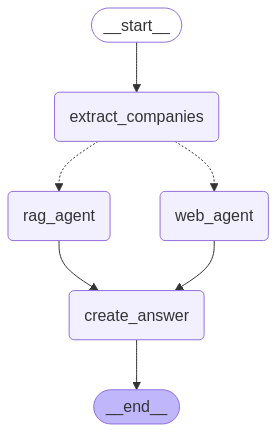

In [72]:
from IPython.display import Image, display
from langgraph.types import Send
from langgraph.graph import START, END, StateGraph
from langchain_core.messages import HumanMessage, SystemMessage
from llama_index.core.vector_stores import MetadataFilter, MetadataFilters, FilterOperator
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core.postprocessor import SimilarityPostprocessor

supervisor_instruction = """You are tasked with analyzing whether the following user prompt relates to one or several DAX 40 companies: {prompt}.

If you find any DAX 40 companies mentioned in the user prompt, map them to the ones mentioned in the following list:
{dax_40}.

It may well be that the user prompt is a more generic question that is not related to any specific company.
"""

topic_extraction_instruction = """You are part of an AI agent designed to answer questions about the risks DAX 40 companies
are facing. 

Your task is to extract the topic of the user prompt. The topic should be a short phrase that summarizes the main subject of the question.

Please make sure to retain specific keywords that are relevant to the topic.

This is the user prompt from which you should extract the topic: {prompt}.

Company names should not be included in the topic.
"""

single_answer_generation_instruction = """Based on the following context for {company}, generate an answer to the topic '{topic}': \n\n {context}.

If the context does not provide enough information, please answer that the annual report of {company} does not provide any information about the topic '{topic}'.
"""

final_answer_generation_instruction = """You are tasked to provide a concise answer to the following prompt: {prompt}.

To respond to the user, you are supposed to use the following contextual information: {context}.

If you find that the context contains repetitive information, please summarize it accordingly.

If the context mentions DAX 40 companies, please make sure to explicitly include them in your answer.
"""


def extract_companies(state: OverallState, dax_40: list = dax_40):

    prompt = state.get('prompt')
    dax_40 = ', '.join(dax_40)
    
    # Enforce structured output
    structured_llm = llm.with_structured_output(Companies)

    # System message
    system_message = supervisor_instruction.format(prompt=prompt, dax_40=dax_40)

    # Extract companies
    companies = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Extract the set of DAX 40 companies if there any mentioned. Otherwise return nothing.")])

    return {'companies': companies.companies}

def route_to_tool(state: OverallState):

    companies = state.get('companies', None)

    if companies is not None:
        prompt = state.get('prompt')

        structured_llm = llm.with_structured_output(Topic)
        system_message = topic_extraction_instruction.format(prompt=prompt)
        topic = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Extract the topic of the user prompt.")])

        return [Send("rag_agent", {"company": c, "topic": topic}) for c in companies]
    
    else:
        return 'web_agent'


def web_agent(state: OverallState):
    
    search_docs = tavily_search.invoke(state['prompt'])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def rag_agent(state: DocumentState, vector_index=vector_index):

    company = state.get('company')
    topic = state.get('topic')

    filters = MetadataFilters(
        filters=[
            MetadataFilter(key="company", operator=FilterOperator.EQ, value=company.name),
        ]
    )

    retriever = vector_index.as_retriever(
        filters=filters, 
        similarity_top_k=2,
        embed_model=HuggingFaceEmbedding(model_name="Snowflake/snowflake-arctic-embed-l-v2.0"))
    
    context = retriever.retrieve(topic.topic)
    # filter nodes below certain similarity score
    processor = SimilarityPostprocessor(similarity_cutoff=0.2)
    filtered_context = processor.postprocess_nodes(context)

    if len(filtered_context) == 0:
        answer = f"The annual report of {company.name} does not provide any information about the topic '{topic.topic}'."
    
    else:
        system_message = single_answer_generation_instruction.format(company=company.name, topic=topic.topic, context=' \n '.join([node.text for node in filtered_context]))
        answer = llm.invoke(system_message).content
    
    return {"context": [answer]}


def create_answer(state: OverallState):
    
    prompt = state.get('prompt')
    context = state.get('context', None)

    system_message = final_answer_generation_instruction.format(prompt=prompt, context='\n\n'.join(context))
    final_answer = llm.invoke(system_message).content

    # Return the company-specific answer
    return {"final_answer": final_answer}


builder = StateGraph(OverallState)
builder.add_node("extract_companies", extract_companies)
builder.add_node("rag_agent", rag_agent)
builder.add_node("web_agent", web_agent)
builder.add_node("create_answer", create_answer)
builder.add_edge(START, "extract_companies")
builder.add_conditional_edges("extract_companies", route_to_tool, ["rag_agent", "web_agent"])
builder.add_edge("web_agent", "create_answer")
builder.add_edge("rag_agent", "create_answer")
builder.add_edge("create_answer", END)
graph = builder.compile()

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [73]:
prompt = "Is beiersdorf facing risks related to the energy transition?"

for event in graph.stream({"prompt": prompt}):
    print(event)

w:\teaching\risk_analytics\.venv\Lib\site-packages\langchain_openai\chat_models\base.py:1547: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(
w:\teaching\risk_analytics\.venv\Lib\site-packages\langchain_openai\chat_models\base.py:1547: UserWarning: Cannot use method='json_schema' with model gpt-4 since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


{'extract_companies': {'companies': [Company(name='beiersdorf')]}}
{'rag_agent': {'context': ["The annual report of Beiersdorf does not provide any information about the topic 'risks related to the energy transition'."]}}
{'create_answer': {'final_answer': "The annual report of Beiersdorf does not provide any specific information regarding risks related to the energy transition. Therefore, it's unclear whether the company is facing such risks."}}
